
# QLIF Neurons - Quickstart Notebook

This notebook gives you a minimal, runnable intro to your **Quantum-inspired LIF (QLIF)** neurons:
- quick spike simulation
- visualization of voltage + spikes
- optional comparison to **Norse** LIF (if installed)

> Works in Colab or locally. If you use Colab, upload your repo or `git clone` it first so the imports resolve.



## 0) Setup (paths & optional installs)

If you're on Colab:
- `git clone` your repo
- then set `REPO_DIR` accordingly below.

If you want the Norse comparison and don't have it installed:
```bash
pip install norse
```


In [28]:

import sys, os, math
from pathlib import Path

# === Adjust this if needed ===
REPO_DIR = Path("../").resolve()  # set to your repo root if running elsewhere

# Make sure repo code is importable
if str(REPO_DIR) not in sys.path:
    sys.path.insert(0, str(REPO_DIR))

print("Using repo dir:", REPO_DIR)


Using repo dir: D:\Users\AJK\git\snn-o1


## 1) Imports

In [29]:

import numpy as np
import torch
import matplotlib.pyplot as plt

try:
    from qlif_layers.qlif_layer import QLIFLayer
except Exception as e:
    print("Falling back to direct neuron import (QLIF). Error was:", e)
    from neurons.qlif import QLIF


## 2) Helper: Generate an input current (ramp + noise)

In [30]:

def generate_input(timesteps: int, batch_size: int, num_neurons: int, noise_level: float):
    pad_left  = timesteps // 4
    ramp_len  = timesteps // 2
    pad_right = timesteps - pad_left - ramp_len

    ramp = torch.linspace(0, 2, ramp_len).repeat(batch_size, num_neurons, 1).permute(2, 0, 1)
    base = torch.cat([
        torch.zeros(pad_left,  batch_size, num_neurons),
        ramp,
        torch.zeros(pad_right, batch_size, num_neurons)
    ], dim=0)
    noise = torch.randn(timesteps, batch_size, num_neurons) * noise_level
    return (base + noise).float()


## 3) Minimal simulation (QLIFLayer)

In [31]:

timesteps = 200
noise_level = 0.15

# Change this four QLIF parameters here to adjust the input current:
batch_size = 1
num_neurons = 6
device = "cpu"  # change to "cuda" if you want to use GPU
use_quantum = False  # flip to False for classic

I = generate_input(timesteps, batch_size, num_neurons, noise_level)
ext_mod = None

layer_cfg = dict(
    num_neurons=num_neurons,
    V_th=1.2,
    V_reset=0.0,
    tau=30.0,
    dt=1.0,
    eta=0.15,
    use_adaptive_threshold=True,
    noise_std=0.05,
    stochastic=True,
    min_threshold=0.5,
    max_threshold=2.0,
    batch_size=batch_size,
    device=device,  # change to "cuda" if you want to use GPU
    surrogate_gradient_function="heaviside",
    alpha=1.0,
    allow_dynamic_spike_probability=True,
    base_alpha=2.0,
    tau_adapt=20.0,
    adaptation_decay=0.9,
    spike_increase=0.5,
    depression_rate=0.1,
    recovery_rate=0.05,
    neuromod_transform=None,
    neuromod_mode="gain",
    neuromod_strength=1.0,
    learnable_threshold=True,
    learnable_tau=False,
    learnable_eta=False,
    learnable_qscale=True,
    learnable_qbias=True,
    quantum_mode=use_quantum,
    quantum_threshold=0.7,
    quantum_leak=0.1,
    quantum_wire=4
)


def run_with_layer():
    lif = QLIFLayer(**layer_cfg)
    lif.eval()
    with torch.no_grad():
        s, v = lif(I, ext_mod)
    return s.squeeze().cpu().numpy(), v.squeeze().cpu().numpy(), I.squeeze().cpu().numpy()


try:
    spikes, volts, inp = run_with_layer()
    print("Ran with QLIFLayer.")
except NameError:
    print("QLIFLayer not available, will use step-by-step QLIF fallback.")
    spikes = volts = inp = None


Ran with QLIFLayer.


In [32]:

if spikes is None:
    from neurons.qlif import QLIF

    T, B, N = I.shape
    neuron = QLIF(
        num_neurons=N,
        V_th=1.2, tau=30.0, device=device,
        stochastic=True, noise_std=0.05,
        use_adaptive_threshold=True,
        quantum_mode=use_quantum, quantum_wire=4,
        quantum_threshold=0.7, quantum_leak=0.1,
    )
    neuron.eval()

    s_np = np.zeros((T, N), dtype=bool)
    v_np = np.zeros((T, N), dtype=np.float32)
    with torch.no_grad():
        for t in range(T):
            s_t = neuron(I[t], None)
            s_np[t, :] = s_t.squeeze().cpu().numpy()
            v_np[t, :] = neuron.V.squeeze().cpu().numpy()
    spikes, volts, inp = s_np, v_np, I.squeeze().cpu().numpy()
    print("Ran with QLIF step-by-step fallback.")


## 4) Plot voltage + spike raster

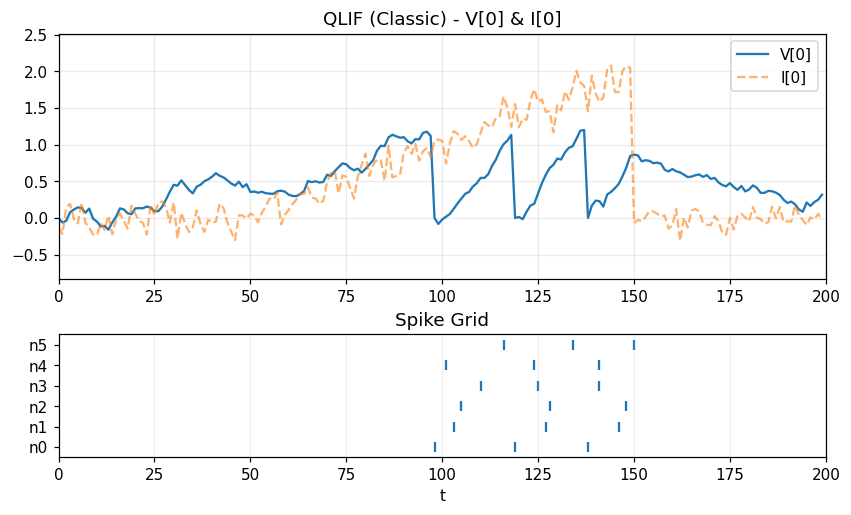

In [33]:

T, N = spikes.shape

fig = plt.figure(figsize=(9, 5), dpi=110)
gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title(f"QLIF ({'Quantum' if use_quantum else 'Classic'}) - V[0] & I[0]")
ax1.set_xlim(0, T)
ax1.set_ylim(min(inp.min(), volts.min())-0.3, max(inp.max(), volts.max())+0.3)
ax1.plot(np.arange(T), volts[:,0], label='V[0]')
ax1.plot(np.arange(T), inp[:,0], '--', alpha=0.6, label='I[0]')
ax1.grid(True, alpha=0.25); ax1.legend()

ax2 = fig.add_subplot(gs[1, 0])
ax2.set_title("Spike Grid")
ax2.set_xlim(0, T); ax2.set_ylim(-0.5, N-0.5)
t_idx, n_idx = np.where(spikes)
ax2.scatter(t_idx, n_idx, marker='|')
ax2.set_xlabel("t")
ax2.set_yticks(range(N)); ax2.set_yticklabels([f"n{j}" for j in range(N)])
ax2.grid(True, axis='x', alpha=0.2)
plt.show()


## 5) Optional: Compare with Norse LIF

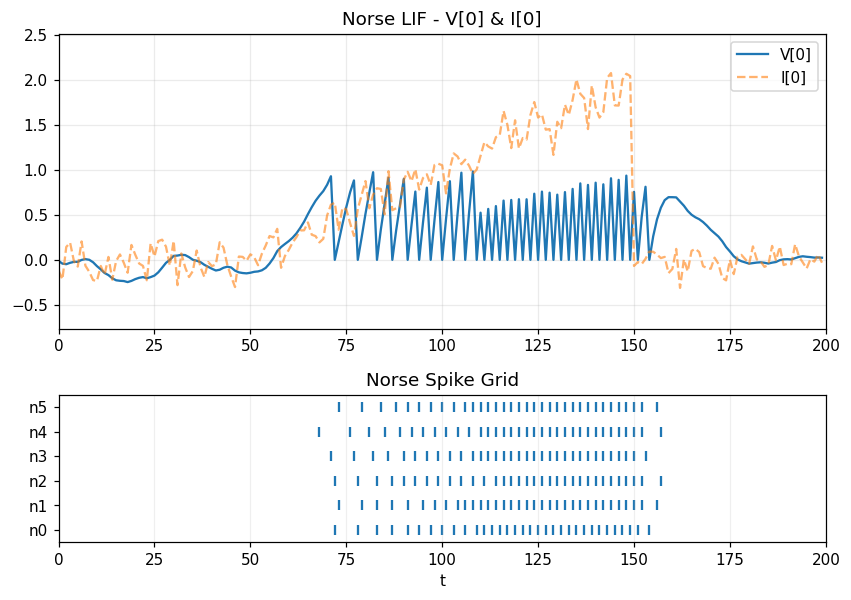

In [34]:

def simulate_norse_lif(I, device="cpu"):
    try:
        from norse.torch.module.lif import LIFCell
    except Exception as e:
        print("Norse not available:", e)
        return None, None

    T, B, N = I.shape
    lif = LIFCell().to(device)
    lif.eval()
    s_np = np.zeros((T, N), dtype=bool)
    v_np = np.zeros((T, N), dtype=np.float32)
    state = None
    with torch.no_grad():
        for t in range(T):
            z, state = lif(I[t].to(device), state)
            v = getattr(state, "v", None)
            s_np[t, :] = (z.squeeze().cpu().numpy() > 0.0)
            v_np[t, :] = 0.0 if v is None else v.squeeze().cpu().numpy()
    return s_np, v_np

n_spikes, n_volts = simulate_norse_lif(I, device=device)
if n_spikes is not None:
    fig = plt.figure(figsize=(9, 6), dpi=110)
    gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.3)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title("Norse LIF - V[0] & I[0]")
    ax1.set_xlim(0, T)
    ax1.set_ylim(min(inp.min(), n_volts.min())-0.3, max(inp.max(), n_volts.max())+0.3)
    ax1.plot(np.arange(T), n_volts[:,0], label='V[0]')
    ax1.plot(np.arange(T), inp[:,0], '--', alpha=0.6, label='I[0]')
    ax1.grid(True, alpha=0.25); ax1.legend()

    ax2 = fig.add_subplot(gs[1, 0])
    ax2.set_title("Norse Spike Grid")
    ax2.set_xlim(0, T); ax2.set_ylim(-0.5, N-0.5)
    t_idx, n_idx = np.where(n_spikes)
    ax2.scatter(t_idx, n_idx, marker='|')
    ax2.set_xlabel("t")
    ax2.set_yticks(range(N)); ax2.set_yticklabels([f"n{j}" for j in range(N)])
    ax2.grid(True, axis='x', alpha=0.2)
    plt.show()
else:
    print("Skip Norse comparison (not installed).")
